In [ ]:
import re
import nltk
import string
import packaging
import spacy
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
!pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('wordnet')

spell = SpellChecker()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


import the dataset from the competition

In [ ]:
import os
df_prompt = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/train_prompts.csv')
df_train_essay = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/train_essays.csv')

import the dataset from the competition

We can see that there is a data imbalance problem between AI and human essays.

There are 1375 human essays, whereas only 3 AI essays in the dataset.

Thus, the next step is to increase the size of the dataset to fix the problem.

In [ ]:
print(df_train_essay[df_train_essay['generated']==0]['generated'].value_counts())
print(df_train_essay[df_train_essay['generated']==1]['generated'].value_counts())

generated
0    1375
Name: count, dtype: int64
generated
1    3
Name: count, dtype: int64


Here, I simply checked the distribution of the prompt_id used in the dataset.

prompt_id 0 has been used 707 times. prompt_id 1 has been used 668 times in the dataset.

There is not so much difference in the dataset.

We will focus more on the content instead of the prompts.

In [ ]:
df_train_essay[df_train_essay['generated'] == 0]['prompt_id'].value_counts()

prompt_id
0    707
1    668
Name: count, dtype: int64

Now we will import the dataset created by other Kaggle contributors for balancing the dataset.

https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train

In [ ]:
# Load external data
ext_df1 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_01.csv')
ext_df2 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_02.csv')
ext_df3 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_03.csv')
ext_df4 = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/daigt/train_drcat_04.csv')


In [ ]:
ext_df5 = pd.concat([ext_df1, ext_df2, ext_df3, ext_df4], axis=0) # Concatenate all the dataframes

In [ ]:
ext_df5['label'].value_counts()

label
0    115372
1     44084
Name: count, dtype: int64

In [ ]:
ext_df5[ext_df5['label'] == 1]['text'].iloc[0]
ext_df5[ext_df5['label'] == 0]['text'].iloc[0]

'There are alot reasons to keep our the despised method of choosing the President. The First reason is because Certainty of Outcome, in the text its states that "The reason is that the winning candidate\'s share of the Electoral College invariably exceeds his share of the popular vote. Another example from the text is "Obama, he recieved 61.7 percent of the electoral vote compared to only 51.3 percent of the popular votes cast for him and Romney... because all of the states award electoral votes on a winner-take-all basis.\n\nAnother reason is that the Electiral College requires a presidential candidate to have trans-regional appeal,in that case, no region has enough electoral votes to elect a president, a solid regional favorite such as Romney was in the South , has no reason to campaign in those states because of the poor economy and because its not a wealthy state, he wont be able to campaign heavily. So he left with no votes and would have to find his Electoral College votes in a m

In [ ]:
# data cleaning
df_train_essay = df_train_essay[['text','generated']]
df_train_essay.rename(columns={'generated':'label'}, inplace=True)

# we took a sample of 4000 from the label 0 (Human) and 5300 from the label 1
ext_df5_0 = ext_df5[ext_df5['label'] == 0].sample(43000)
ext_df5_1 = ext_df5[ext_df5['label'] == 1].sample(44000)

# concatenate the dataframes from the external data for the two labels
ext_df2 = pd.concat([ext_df5_0, ext_df5_1])
ext_df5_final = pd.concat([df_train_essay, ext_df2])

# drop the columns that are not needed
ext_df5_final.drop(columns=['essay_id','source','prompt','fold'],inplace=True)

# check the distribution of the labels once again
ext_df5_final['label'].value_counts()

#ext_df5_final.to_csv('C:\\Users\\user\\OneDrive - University of Sussex\\Second Semester\\Dissertation\\llm-detect-ai-generated-text\\extended_dataset\\dataset_balanced.csv', index=False)

<ipython-input-11-ba6880181501>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_essay.rename(columns={'generated':'label'}, inplace=True)


label
0    44375
1    44003
Name: count, dtype: int64

Import the dataset generated by the twisted prompts. In order to build a model that won't be fooled by the human-like generated essays, twisted prompts like "Based on this specific topic, generate an essay using this format of the writing style(an example essay is provided). Write the essay as if it were writen by a middle school student."

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')

prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)
combine_dataset = pd.concat([ext_df3, prompt_essays],axis=0)

#### To gain insight  into how similar the AI-generated essays are, we randomly sampled a subset of 2,000 essays and calculated the pairwise 3-gram cosine similarities for all possible pairs. We then looked at the share of pairs that exceed a given similarity threshold of 0.05.

In [ ]:
ext_df5_final_0_5000 = ext_df5_final[ext_df5_final['label'] == 0].sample(5000)
ext_df5_final_1_5000 = ext_df5_final[ext_df5_final['label'] == 1].sample(5000)
mixed_essays = pd.concat([ext_df5_final[ext_df5_final['label'] == 0].sample(2500),ext_df5_final[ext_df5_final['label'] == 1].sample(2500)],axis=0)
prompt_essays_1 = prompt_essays[prompt_essays['label']==1]
prompt_essays_0 = prompt_essays[prompt_essays['label']==0]
mix_prompt_essays = pd.concat([prompt_essays_0,prompt_essays_1],axis=0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import itertools


# Define a function to calculate cosine similarities and statistics
def calculate_statistics(essays):
    vectorizer = CountVectorizer(ngram_range=(3, 3))  # 3-grams
    X = vectorizer.fit_transform(essays)
    cos_similarities = cosine_similarity(X)

    # Get all pairwise similarities excluding self-pairs
    pairs = list(itertools.combinations(range(len(essays)), 2))
    similarity_scores = [cos_similarities[i, j] for i, j in pairs]

    # Calculate mean and standard deviation
    mean_similarity = np.mean(similarity_scores)
    std_similarity = np.std(similarity_scores)

    return mean_similarity, std_similarity, similarity_scores

# Calculate statistics for each group
ai_mean, ai_std, ai_scores = calculate_statistics(list(ext_df5_final_1_5000['text']))
human_mean, human_std, human_scores = calculate_statistics(list(ext_df5_final_0_5000['text']))
mixed_mean, mixed_std, mixed_scores = calculate_statistics(list(mixed_essays['text']))
prompt_essays_1_mean, prompt_essays_1_std, prompt_essays_1_scores = calculate_statistics(list(prompt_essays_1['text']))
prompt_essays_0_mean, prompt_essays_0_std, prompt_essays_0_scores = calculate_statistics(list(prompt_essays_0['text']))
mix_prompt_essays_mean, mix_prompt_essays_std, mix_prompt_essays_scores = calculate_statistics(list(mix_prompt_essays['text']))

# Print results
print(f"AI-Generated Essays: Mean Similarity = {ai_mean:.4f}, Std Dev = {ai_std:.4f}")
print(f"Human-Written Essays: Mean Similarity = {human_mean:.4f}, Std Dev = {human_std:.4f}")
print(f"Mixed Essays: Mean Similarity = {mixed_mean:.4f}, Std Dev = {mixed_std:.4f}")
print(f"Prompt Essays (Label AI): Mean Similarity = {prompt_essays_1_mean:.4f}, Std Dev = {prompt_essays_1_std:.4f}")
print(f"Prompt Essays (Label Human): Mean Similarity = {prompt_essays_0_mean:.4f}, Std Dev = {prompt_essays_0_std:.4f}")
print(f"Mixed Prompt Essays: Mean Similarity = {mix_prompt_essays_mean:.4f}, Std Dev = {mix_prompt_essays_std:.4f}")

AI-Generated Essays: Mean Similarity = 0.0057, Std Dev = 0.0168
Human-Written Essays: Mean Similarity = 0.0047, Std Dev = 0.0155
Mixed Essays: Mean Similarity = 0.0037, Std Dev = 0.0136
Prompt Essays (Label AI): Mean Similarity = 0.0121, Std Dev = 0.0185
Prompt Essays (Label Human): Mean Similarity = 0.0364, Std Dev = 0.0587
Mixed Prompt Essays: Mean Similarity = 0.0127, Std Dev = 0.0332


If the proportion of AI-generated essay pairs exceeding the 0.05 threshold was significantly higher than that of human-written essays, it would suggest that the AI model tends to produce more repetitive content. Conversely, a low proportion would indicate that the AI model generates diverse and unique responses.

The human-written essays served as a control group. The expected lower proportion of similar pairs among these essays would affirm that human-authored content is typically more varied.

It makes sense to see, in general, the AI content has higher similiarity score than human content. For the twisted prompt content, since AI content was generated by different prompts, lower similiarity score is expected.

# Experiment 1 (TFIDF and BERT word representations and feed to the LogisticRegression and BERT model.)

Below is the reuslt of using the simple BoW model to classify the Ai and human essays.

The result shows that around 98 percent of the eassys can be predicted correctly.

Later, we will try to use the BERT model for the same test.

In [ ]:
def preprocess_text(text):
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Convert text to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenize and remove stop words, then lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


# Preprocess the text ext_df5_final
ext_df5_final['preprocessed_text'] = ext_df5_final['text'].apply(preprocess_text)

# Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text to a TF-IDF representation
X = vectorizer.fit_transform(ext_df5_final['preprocessed_text'])

# Split the ext_df5_final
X_train, X_val, y_train, y_val = train_test_split(X, ext_df5_final['label'], test_size=0.2, random_state=42)

print("Revised ext_df5_final preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_train)

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_val, binary_predictions, target_names=['Human essays', 'AI essays'], output_dict=True)

# Convert the classification report to ext_df5_finalFrame
report_df = pd.ext_df5_finalFrame(binary_classification_report).transpose()
print(report_df)

# Feature importance
feature_names = vectorizer.get_feature_names_out()
coefficients = binary_classifier.coef_[0]
feature_importance = pd.ext_df5_finalFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

# Count occurrences of each feature using CountVectorizer
count_vectorizer = CountVectorizer(vocabulary=feature_names)
X_counts = count_vectorizer.fit_transform(ext_df5_final['preprocessed_text'])

# Create a sparse ext_df5_finalFrame
counts_df = pd.ext_df5_finalFrame.sparse.from_spmatrix(X_counts, columns=count_vectorizer.get_feature_names_out())

# Reset indices to ensure alignment
counts_df.reset_index(drop=True, inplace=True)
ext_df5_final.reset_index(drop=True, inplace=True)

# Split counts by label
ai_counts = counts_df[ext_df5_final['label'] == 1]
human_counts = counts_df[ext_df5_final['label'] == 0]

# Sum counts for each feature
ai_feature_counts = ai_counts.sum(axis=0)
human_feature_counts = human_counts.sum(axis=0)

# Combine with feature importance ext_df5_final
feature_importance['ai_count'] = ai_feature_counts.values
feature_importance['human_count'] = human_feature_counts.values

# Print the combined ext_df5_final with counts
print("Top 20 features for AI essays with counts:")
print(feature_importance.head(20))
print("==========================================================")
print("Top 20 features for Human essays with counts:")
print(feature_importance.tail(20))

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.1 MB/s eta 0:00:00


AI content: Words like conclusion / important / additionally / essay are often used in the AI content.

# Experiment 2 (Twisted Prompts analysis )

In [ ]:
# List of pronouns
pronouns = set([
    'i', 'me', 'my', 'mine', 'myself',
    'we', 'us', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself',
    'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves'
])

# Function to check word length
def check_word_length(text):
    words = word_tokenize(text)
    if len(words) == 0:
        return 0
    avg_word_length = np.mean([len(word) for word in words])
    return avg_word_length

# Function to check sentence length
def check_sentence_length(text):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    avg_sentence_length = np.mean([len(sentence) for sentence in sentences])
    return avg_sentence_length

# Function to check pronoun usage
def check_pronouns(text):
    words = word_tokenize(text.lower())
    pronoun_count = sum(1 for word in words if word in pronouns)
    return pronoun_count

# Function to check spelling mistakes
def check_spelling(text):
    words = word_tokenize(text)
    misspelled = spell.unknown(words)
    return len(misspelled)

# Function to check passive voice
def check_passive_voice(text):
    sentences = sent_tokenize(text)
    passive_sentences = 0
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged = nltk.pos_tag(words)
        if 'VBN' in [tag for word, tag in tagged] and any(aux in [word for word, tag in tagged] for aux in ['was', 'were', 'is', 'been']):
            passive_sentences += 1
    return passive_sentences

# NER function to count named entities
def count_named_entities(text):
    doc = nlp(text)
    entity_count = len(doc.ents)
    return entity_count

# Human Authorship Score
def presence_score(text):
    doc = nlp(text)
    personal_pronouns = sum(1 for token in doc if token.pos_ == "PRON" and token.lower_ in pronouns)
    informal_phrases = sum(1 for token in doc if token.lower_ in ["hey", "lol", "omg", "brb", "btw", "idk", "jk", "tbh", "tbt", "ttyl", "wtf", "yolo", "smh", "lmao", "rofl", "omfg", "oml", "omw", "ofc", "fml", "imo", "imho", "irl", "nvm", "tmi", "tldr", "ygm", "yolo", "yoloing"])
    score = personal_pronouns + informal_phrases
    return score

# Philosophical Sentiment Score
def sentiment_score(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

# Abstract Concepts Score
abstract_concepts_set = {"love", "freedom", "justice", "beauty", "truth", "ethics", "philosophy", "morality", "knowledge", "wisdom",
                         "intelligence", "consciousness", "happiness", "suffering", "empathy", "compassion", "altruism", "creativity",
                         "imagination", "curiosity", "intuition", "spirituality", "faith", "religion", "belief", "doubt", "fear", "anxiety",
                         "depression", "stress", "trauma", "healing", "forgiveness", "reconciliation", "redemption", "salvation", "damnation",
                         "sin", "virtue", "vice", "sin", "evil", "good", "bad", "right", "wrong", "justice", "injustice", "equality",
                         "inequality", "free","will", "determinism", "fate", "destiny", "time", "space", "reality", "illusion", "dream",
                         "nightmare", "life", "death", "birth", "existence", "essence", "nature", "nurture", "mind", "body", "soul",
                         "spirit", "consciousness", "unconsciousness", "subconsciousness", "ego", "id", "superego", "self", "other",
                         "us", "them", "we", "they", "me", "you", "he", "she", "it", "they", "we", "us", "them", "this", "that", "here",
                         "there", "now", "then", "always", "never", "sometimes", "maybe", "perhaps", "possibly", "impossible",
                         "possible", "certain", "uncertain", "doubtful", "doubtless", "sure", "unsure", "true", "false", "real",
                         "unreal", "actual", "potential", "past", "present", "future", "beginning", "middle", "end", "start",
                         "stop", "go", "come", "arrive", "leave", "stay", "move", "change", "same", "different", "similar", "opposite",
                         "equal", "unequal", "greater", "lesser", "more"}

def concept_score(text):
    doc = nlp(text)
    abstract_concepts = sum(1 for token in doc if token.lemma_.lower() in abstract_concepts_set)
    return abstract_concepts

# Cultural References Score
cultural_references_set = {"Shakespeare", "Einstein", "Da Vinci", "Mozart", "Buddha", "Jesus", "Muhammad", "Gandhi", "Newton", "Plato",
                           "Aristotle", "Socrates", "Descartes", "Kant", "Hegel", "Marx", "Freud", "Darwin", "Hawking", "Turing", "Picasso",
                           "Van Gogh", "Beethoven", "Mozart", "Bach", "Wagner", "Machiavelli", "Nietzsche", "Dostoevsky", "Tolstoy",
                           "Shakespeare", "Dickens", "Hemingway", "Fitzgerald", "Orwell", "Kafka", "Joyce", "Woolf", "Proust", "Camus",
                           "Sartre", "Kierkegaard", "Heidegger", "Wittgenstein", "Hume", "Locke", "Berkeley", "Russell", "Popper", "Kuhn",
                           "Foucault", "Derrida", "Deleuze", "Baudrillard", "Zizek", "Chomsky"}

def culture_score(text):
    doc = nlp(text)
    cultural_references = sum(1 for token in doc if token.lemma_ in cultural_references_set)
    return cultural_references

# Famous References Score
def get_dbpedia_famous_people():
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    query = """
    SELECT ?person ?personLabel WHERE {
      ?person rdf:type dbo:Person .
      ?person rdfs:label ?personLabel .
      FILTER (lang(?personLabel) = 'en')
    } LIMIT 100
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return [result['personLabel']['value'] for result in results['results']['bindings']]

famous_people = get_dbpedia_famous_people()

def fame_score(text):
    doc = nlp(text)
    famous_references = sum(1 for token in doc if token.lemma_ in famous_people)
    return famous_references

# Metaphors Score
def metaphor_score(text):
    doc = nlp(text)
    metaphors = sum(1 for sent in doc.sents if re.search(r'\b(as\s+\w+\s+as|like\s+a|is\s+a\s+)\b', sent.text, re.IGNORECASE))
    return metaphors

# Multi-dimensional Analysis Function
def multi_dimensional_analysis(text):
    scores = {
        'word_length': check_word_length(text),
        'sentence_length': check_sentence_length(text),
        'pronouns': check_pronouns(text),
        'spelling': check_spelling(text),
        'passive_voice': check_passive_voice(text),
        'named_entities': count_named_entities(text),
        'human_authorship': presence_score(text),
        'philosophical_sentiment': sentiment_score(text),
        'abstract_concepts': concept_score(text),
        'cultural_references': culture_score(text),
        'famous_references': fame_score(text),
        'metaphors': metaphor_score(text)
    }
    return scores


### Twisted prompts AI essays with non-twisted prompts AI essays comparsion

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')
prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)
ext_df5_final_1_100 = ext_df5_final[ext_df5_final['label'] == 1].sample(50)
ext_df5_final_1_100['label'] = 0 # 0 is non twisted prompted AI essays
prompt_essays_1 = prompt_essays[prompt_essays['label']==1]
mix_AI_prompt_essays = pd.concat([ext_df5_final_1_100,prompt_essays_1],axis=0)
mix_AI_prompt_essays.reset_index(drop=True,inplace=True)
mix_AI_prompt_essays['analysis'] = mix_AI_prompt_essays['text'].apply(multi_dimensional_analysis)

analysis_df = pd.json_normalize(mix_AI_prompt_essays['analysis'])
data = mix_AI_prompt_essays.drop(columns=['analysis']).join(analysis_df)

In [ ]:
analysis_df = pd.json_normalize(mix_AI_prompt_essays['analysis'])
data = mix_AI_prompt_essays.drop(columns=['analysis']).join(analysis_df)

<ipython-input-19-a19151fcad03>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
<ipython-input-19-a19151fcad03>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
<ipython-input-19-a19151fcad03>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
<ipython-input-19-a19151fcad03>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
<ipython-input-19-a19151fcad03>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
<ipython-input-

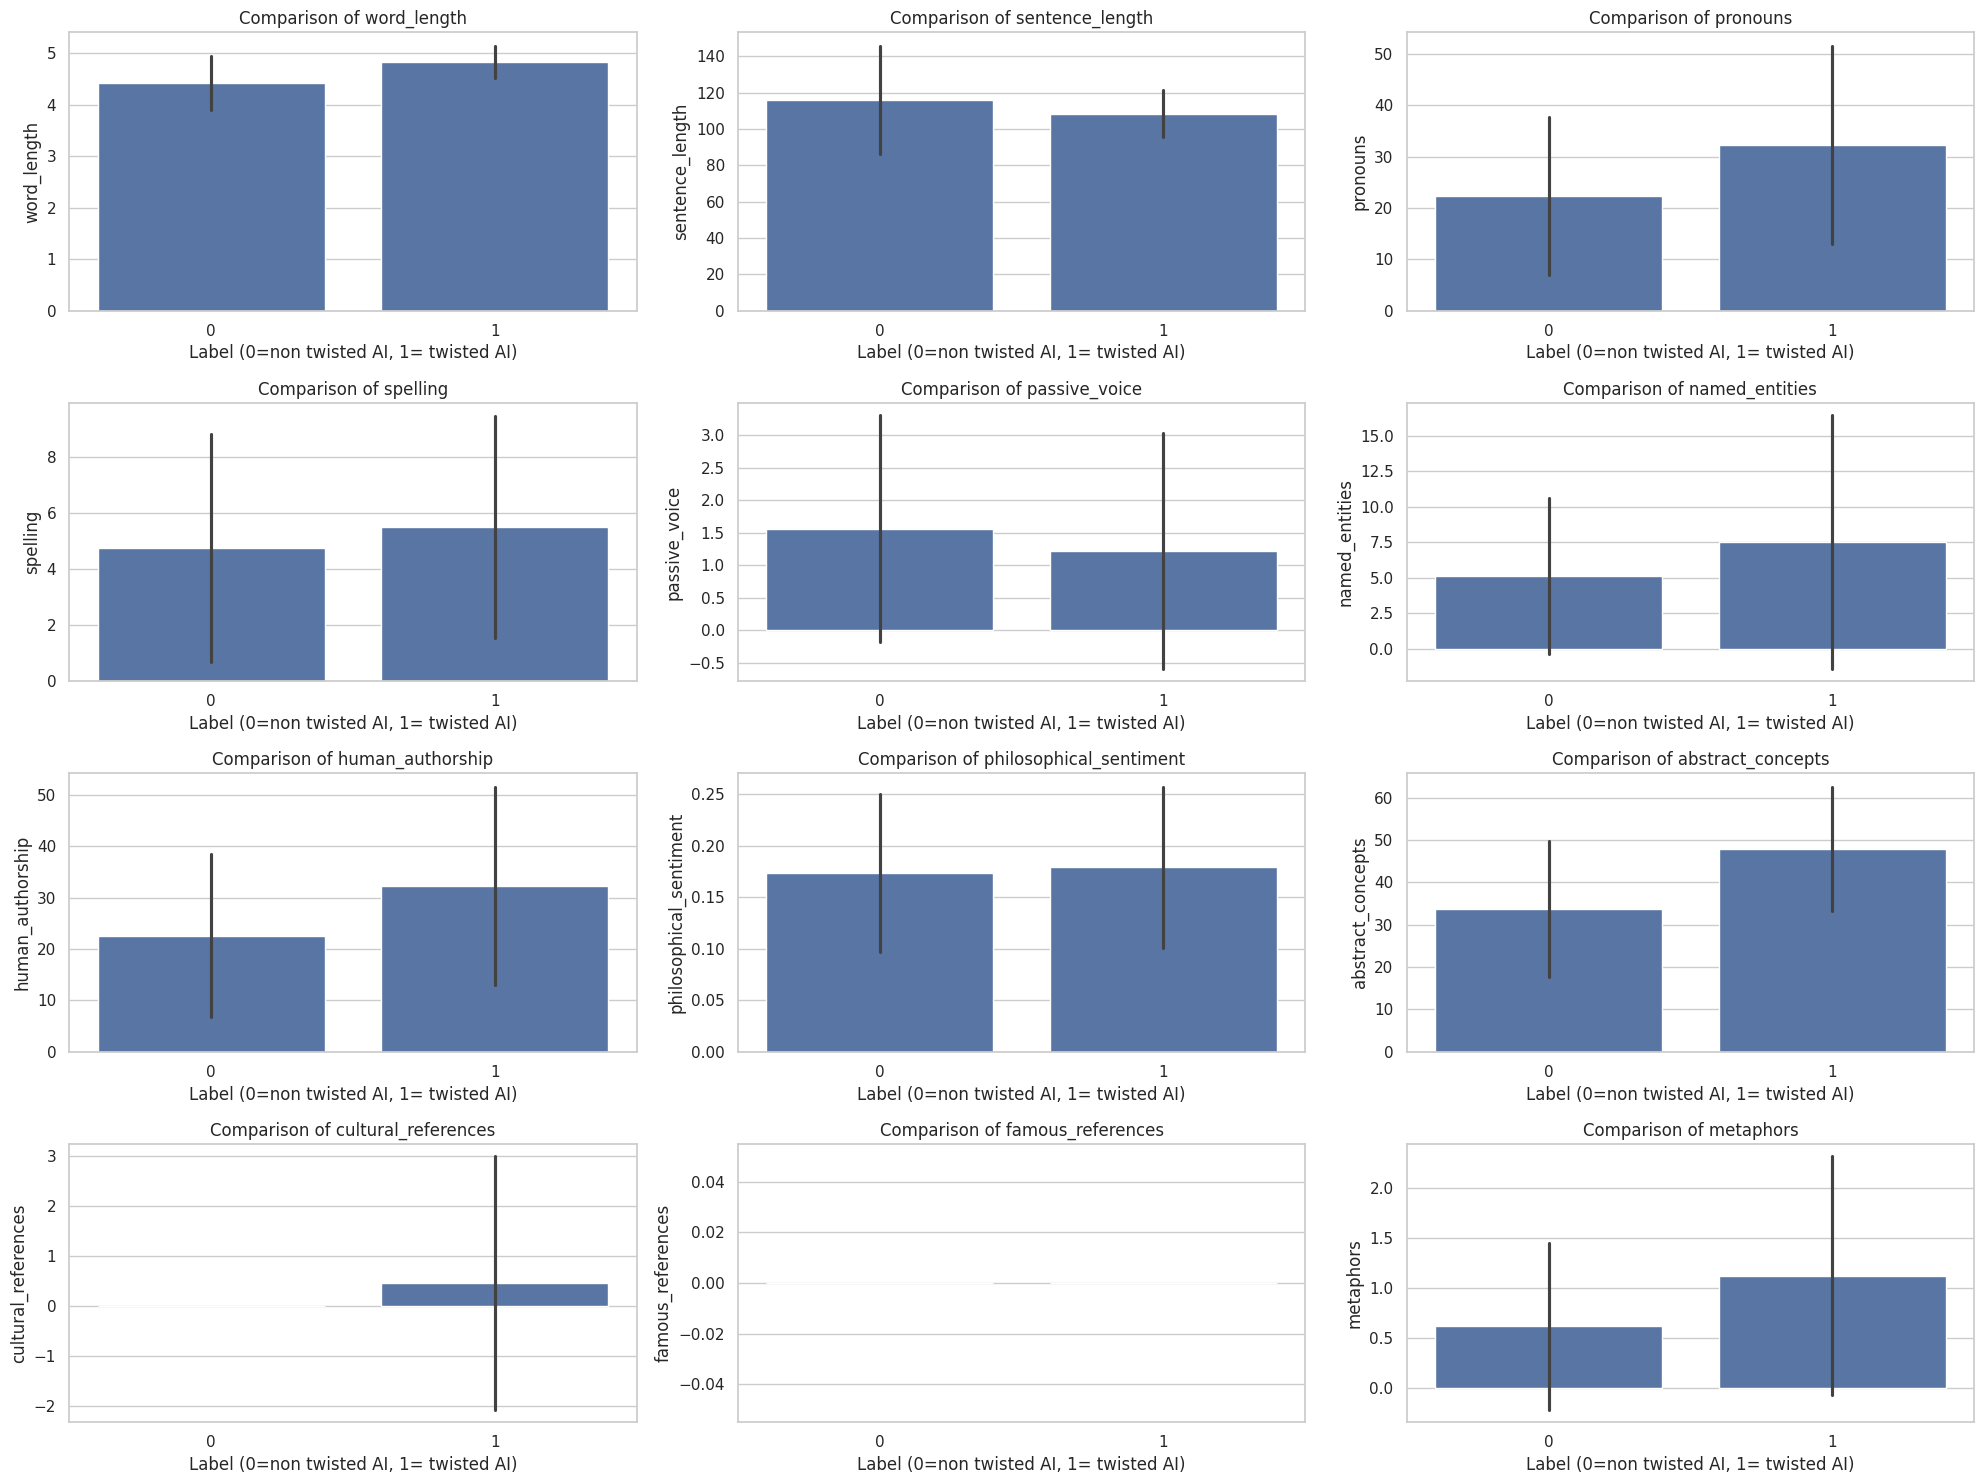

In [ ]:
# features usage
features = [
    'word_length', 'sentence_length', 'pronouns', 'spelling', 'passive_voice',
    'named_entities', 'human_authorship', 'philosophical_sentiment',
    'abstract_concepts', 'cultural_references', 'famous_references', 'metaphors'
]

# Set the style of the visualization
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
    axes[i].set_title(f'Comparison of {feature}')
    axes[i].set_xlabel('Label (0=non twisted AI, 1= twisted AI)')
    axes[i].set_ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

### Twisted prompts AI essays with human essays comparsion

In [ ]:
prompt_essays = pd.read_csv('/content/drive/My Drive/llm-detect-ai-generated-text/extended_dataset/twisted_prompt.csv',encoding='latin1')
prompt_essays.drop(columns=['no.'],inplace=True)
prompt_essays.rename(columns={'content':'text'},inplace=True)

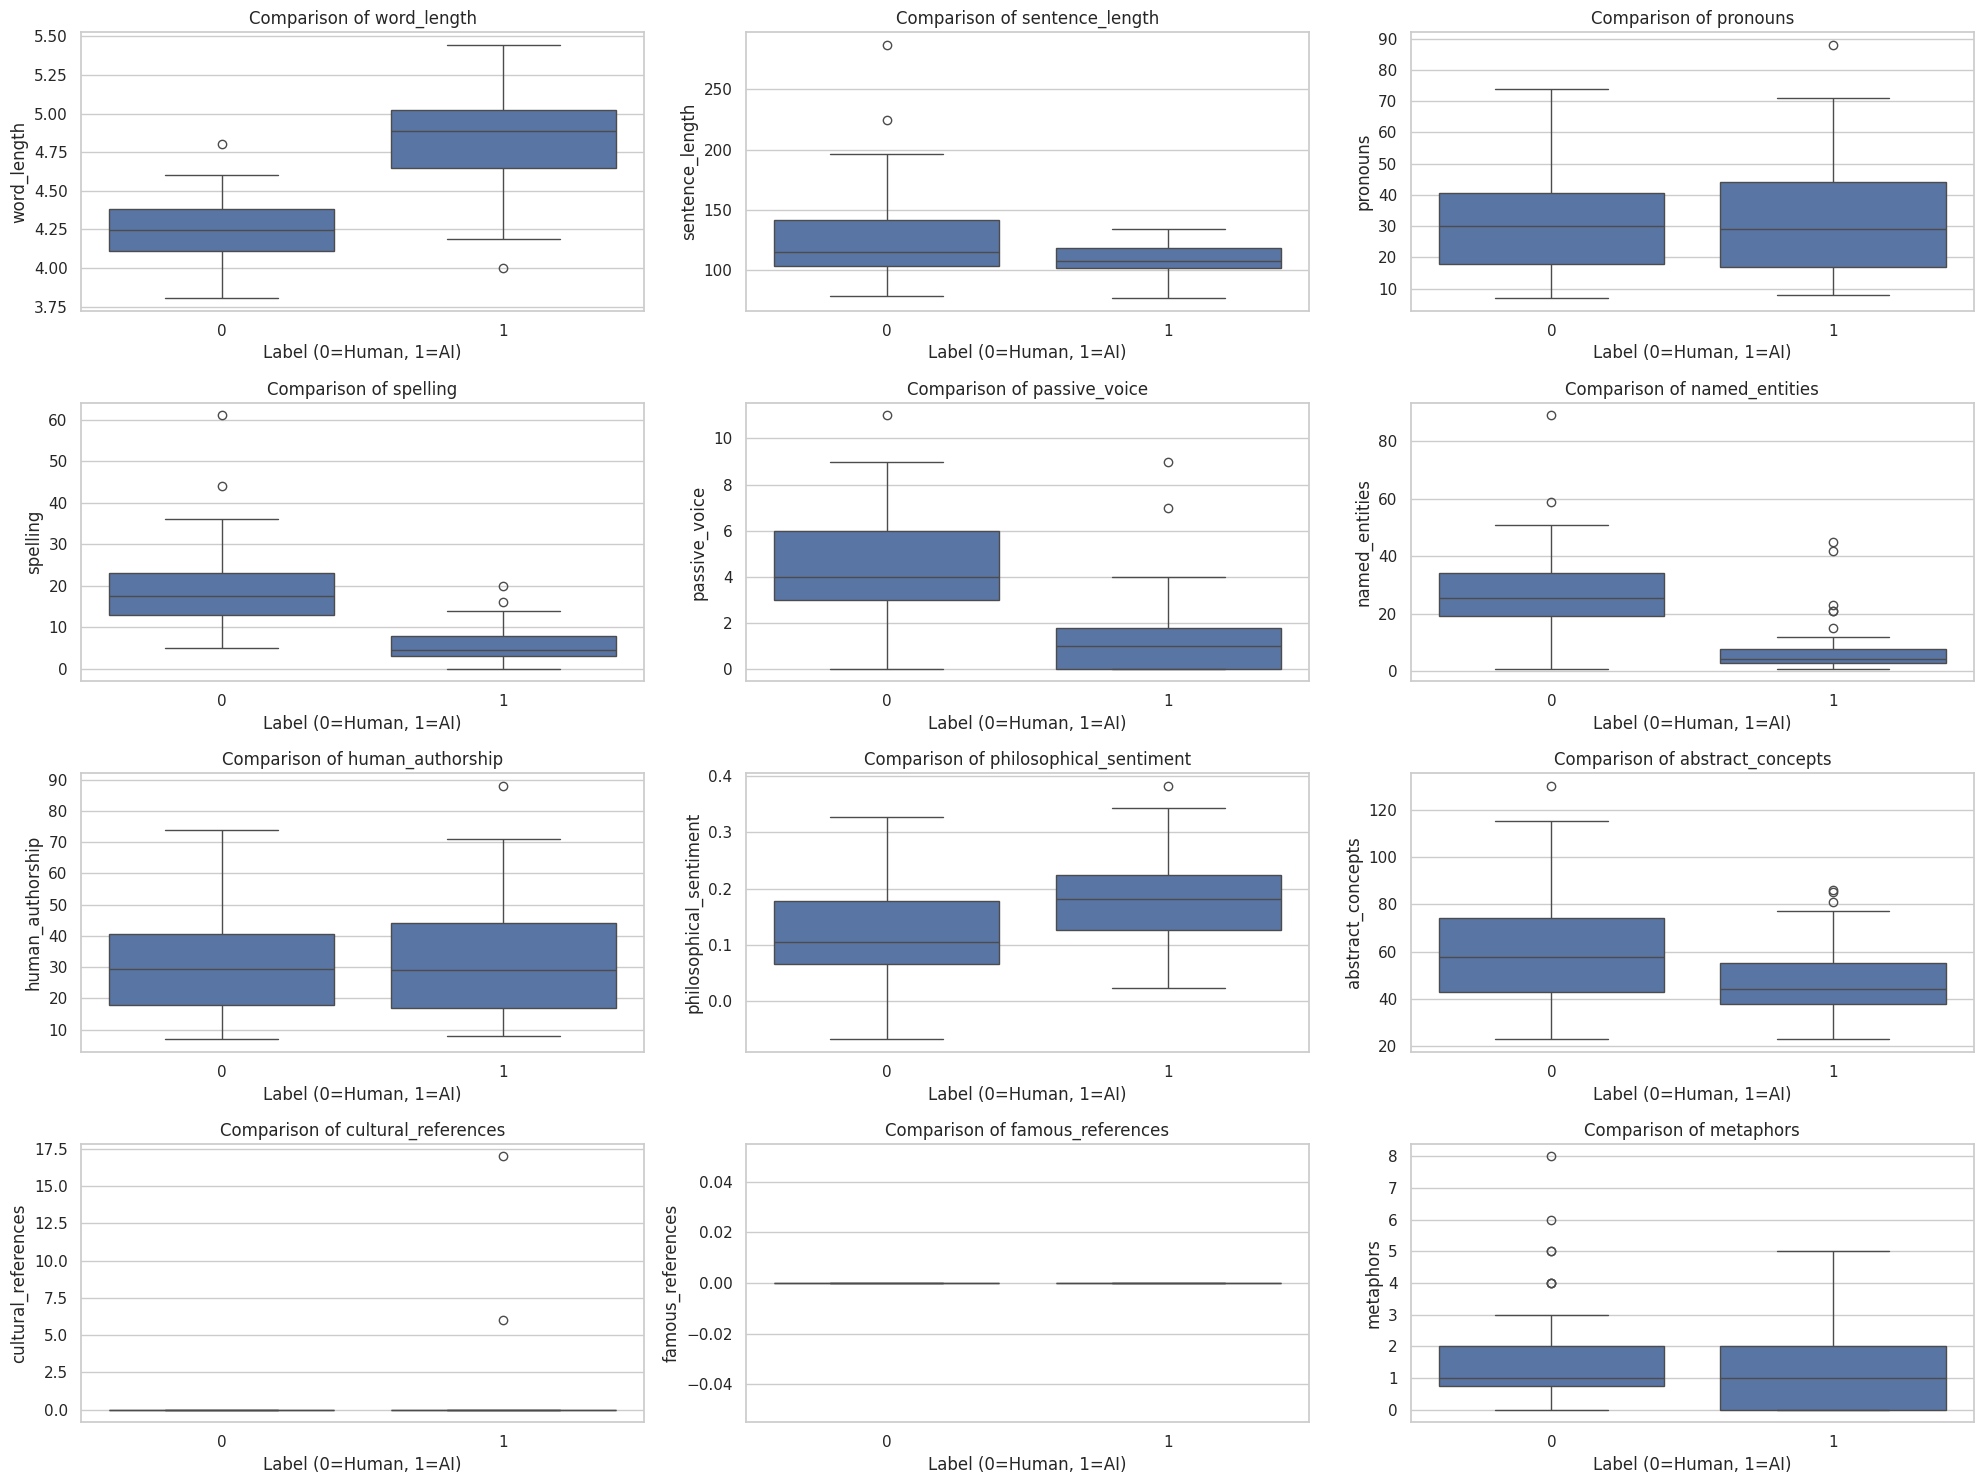

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'multi_dimensional_analysis' is defined and available

def plot_box_plots(data, features):
    """
    Plot box plots for the given features in the dataset.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the text and label.
    features (list): The list of features to plot.
    """
    # Apply the analysis function
    data['analysis'] = data['text'].apply(multi_dimensional_analysis)
    analysis_df = pd.json_normalize(data['analysis'])
    data = data.drop(columns=['analysis']).join(analysis_df)
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='label', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Comparison of {feature}')
        axes[i].set_xlabel('Label (0=Human, 1=AI)')
        axes[i].set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_bar_charts(data, features):

    # Apply the analysis function
    data['analysis'] = data['text'].apply(multi_dimensional_analysis)
    analysis_df = pd.json_normalize(data['analysis'])
    data = data.drop(columns=['analysis']).join(analysis_df)
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.barplot(x='label', y=feature, data=data, ax=axes[i], ci="sd")
        axes[i].set_title(f'Comparison of {feature}')
        axes[i].set_xlabel('Label (0=Human, 1=AI)')
        axes[i].set_ylabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Plot box plots
plot_box_plots(prompt_essays, features)



combine both essays from twisted prompts and non-twisted prompts

In [ ]:
combine_dataset = pd.concat([ext_df5_final,prompt_essays],axis=0)

In [ ]:
# Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the extracted spans to a TF-IDF representation
X = vectorizer.fit_transform(combine_dataset['text'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, combine_dataset['label'], test_size=0.2, random_state=42)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=42)
binary_classifier.fit(X_train, y_train)

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_val, binary_predictions, target_names=['Human essays', 'AI essays'], output_dict=True)

# Convert the classification report to DataFrame
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)

# Feature importance
feature_names = vectorizer.get_feature_names_out()
coefficients = binary_classifier.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

print("Top 10 features for AI essays:")
print(feature_importance.head(20))  # Top 20 features for AI essays
print("==========================================================")
print("Top 10 features for Human essays:")
print(feature_importance.tail(20))  # Top 20 features for Human essays


Revised data preparation complete. Features and labels ready for model training.
              precision    recall  f1-score      support
Human essays   0.978102  0.979890  0.978995  1094.000000
AI essays      0.979245  0.977401  0.978322  1062.000000
accuracy       0.978664  0.978664  0.978664     0.978664
macro avg      0.978674  0.978646  0.978659  2156.000000
weighted avg   0.978665  0.978664  0.978664  2156.000000
Top 10 features for AI essays:
            feature  coefficient
2073            and     4.941965
26096            re     4.824647
16660     important     3.909791
19096          like     3.046058
7166     conclusion     2.766755
1131   additionally     2.517769
21182          name     2.494760
24642     potential     2.435081
35479         while     2.402745
25559       provide     2.312129
31236         super     2.207828
12105         essay     2.167374
3879        believe     2.072254
3952       benefits     2.055526
16047       however     1.974071
18767          lea

# Experiment 3 Tf Idf and BERT vector representation concatenation

In [ ]:
import torch
from transformers import BertTokenizer, BertModel


# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(combine_dataset['text'])

# Initialize the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate BERT embeddings for all texts
X_bert = np.array([get_bert_embeddings(text) for text in combine_dataset['text']])

# Concatenate TF-IDF and BERT features
import scipy.sparse
X_combined = scipy.sparse.hstack((X_tfidf, X_bert))

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_combined, combine_dataset['label'], test_size=0.2, random_state=22)

print("Revised data preparation complete. Features and labels ready for model training.")

# Train binary classifier
binary_classifier = LogisticRegression(random_state=22)
binary_classifier.fit(X_train, y_train)

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_val)
binary_classification_report = classification_report(y_val, binary_predictions, target_names=['Human essays', 'AI essays'], output_dict=True)

# Convert the classification report to DataFrame
report_df = pd.DataFrame(binary_classification_report).transpose()
print(report_df)
